# CNTK Простейшая логистическая регрессия на CNTK

Этот пример построен на основе примера **CNTK 101: Logistic Regression and ML Primer**, доступного в [этой библиотеке](http://notebooks.azure.com/library/cntk).


## Введение

**Задача**:
Мы будем рассматривать задачу классификации опухолей на злокачественные и доброкачественные, в зависимости от размера опухоли и возраста пациента.
<img src="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400>

**Цель**:
Построить классификатор, который будет классифицировать опухоль по заданным параметрам, т.е. разделить эти два класса.

<img src="https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400>


## Логистическая регрессия 
Мы будем использовать однослойную нейронную сеть, которая по сути эквивалентна линейной логистической регрессии. Классификатор будет генерировать вероятность в интервале [0,1] которую затем можно сравнить с пороговым значением (например, 0.5) для получения чёткого ответа (0 или 1). 

<img src="https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200>

В качестве нелинейной функции мы используем сигмоиду, которая приводит сумму к интервалу [0,1].



In [17]:
# Компоненты, которые нам понадобятся
import numpy as np
import sys
import os
from cntk import Trainer
from cntk.device import cpu, set_default_device
from cntk.learner import sgd
from cntk.ops import *

## Генерируем начальные данные
Для начала сгенерируем случайные данные. В нашем случае мы имеем две фичи (age, size) и два класса, представляемые красными и синими точками.

In [18]:
# Параметры сети
input_dim = 2
num_classes = 2
sample_size = 200

### Входные данные

В нашем случае мы генерируем случайные входные данные. В жизни обычно используют [reader][], который читает входные данных из какого-либо источника.

Важно привести входные переменные к некоторому стандартному диапазону, поэтому мы используем *приведенный возраст*.

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93

In [19]:
np.random.seed(0)

labels = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

features = (np.random.randn(sample_size, input_dim)+3) * (labels+1)
features = features.astype(np.float32)    
    
class_ind = [labels==class_number for class_number in range(num_classes)]
labels = np.asarray(np.hstack(class_ind), dtype=np.float32)

for i in range(5):
    print ("{0} -> {1}".format(features[i],labels[i]))

[ 1.83485019  3.90082645] -> [ 1.  0.]
[ 6.93132496  2.92751265] -> [ 0.  1.]
[ 8.97650433  9.79177856] -> [ 0.  1.]
[ 4.1787796   2.82007527] -> [ 1.  0.]
[ 3.85849476  8.10890388] -> [ 0.  1.]


Теперь визуализируем данные

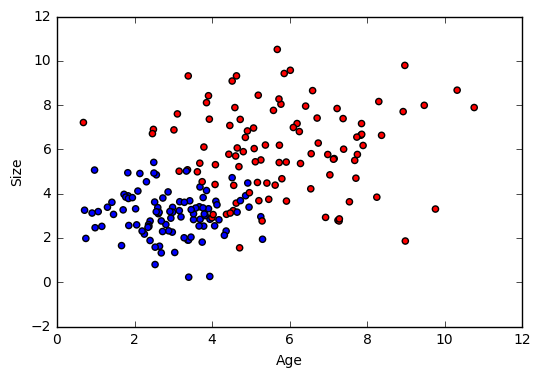

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age")
plt.ylabel("Size")
plt.show()

Разобьем данные на обучающую и тестовую выборки

In [21]:
features_test, features_train = np.split(features,[20])
labels_test, labels_train = np.split(labels,[20])

# Создаём модель

<img src="https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200>

Как мы знаем, один слой нейронов может быть описан следующим уравнением

$$z = f(\sum_{i=1}^n w_i \times x_i + b) = f(\textbf{w} \cdot \textbf{x} + b)$$ 

Здесь $f$ - это сигмоидальная функция.

Для начала, определяем специальную **входную переменную**. Это шаблон, в который записываются данные в процессе обучения сети и затем в процессе вычисления результата.

In [22]:
input = input_variable(input_dim, np.float32)

## Описание сети

Для описания сети мы по сути дела записываем приведенное выше уравнение

In [23]:
weight_param = parameter(shape=(input_dim, num_classes))
bias_param = parameter(shape=(num_classes))
z = times(input, weight_param) + bias_param

## Обучение
Далее, к полученному вектору $z$ надо применить сигмоиду (которая в общем случае называется функцией **softmax**, преобразующей произвольный $n$-мерный вектор к соответствующему вектору со значениями в интервале [0,1]).

Обучение состоит в минимизации некоторой функции ошибки. В качестве такой функции обычно используют **cross-entropy loss**. Вычисление softmax и cross-entropy loss делается одной функцией.

In [24]:
label = input_variable((num_classes), np.float32)
loss = cross_entropy_with_softmax(z, label)
eval_error = classification_error(z, label)

Обучение состоит в оптимизации модели с помощью какого-либо метода оптимизации. В нашем случае используем **стохастический градиентный спуск** (SGD).

Для оптимизации вычислений обычно обрабатывают не по одному элементу входных данных, а сразу используют некоторое подмножество значений, называемое **minibatch**. Затем считают функцию потери loss по всем результатам, и оптимизируют эту ошибку.

Также, на каждой итерации мы меняем параметры не кардинально, а умножая на некоторый коэффициент, называемый **learning rate**.

In [25]:
learner = sgd(z.parameters, lr=0.02)
trainer = Trainer(z, loss, eval_error, [learner])

Определим некоторые вспомогательные функции, которые помогут нам визуализировать то, что происходит

In [26]:
from cntk.utils import get_train_eval_criterion, get_train_loss

def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]
    return [val if idx<w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

### Запускаем обучение

Будем обучать нашу модель на генерируемых точках, по 25 точек за раз (**minibatch**). Общее количество примеров пусть будет 20000.

In [27]:
minibatch_size = 20
num_minibatches_to_train = len(features_train)/minibatch_size
epochs = 17

In [28]:
training_progress_output_freq = 10

plotdata = {"epoch":[], "loss":[], "error":[]}

for ep in range(epochs):
    perm = np.random.permutation(len(features_train))
    for i in range(0, len(features_train), minibatch_size):
        feat = features_train[perm[i:i+minibatch_size]]
        labs = labels_train[perm[i:i+minibatch_size]]
        trainer.train_minibatch({input : feat, label : labs})

    loss = get_train_loss(trainer)
    error = get_train_eval_criterion(trainer)

    print ("Epoch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(ep, loss, error))
    
    plotdata["epoch"].append(ep)
    plotdata["loss"].append(loss)
    plotdata["error"].append(error)

Epoch: 0, Loss: 5.3390, Error: 0.50
Epoch: 1, Loss: 1.6056, Error: 0.55
Epoch: 2, Loss: 0.4475, Error: 0.35
Epoch: 3, Loss: 5.0592, Error: 0.50
Epoch: 4, Loss: 5.0991, Error: 0.55
Epoch: 5, Loss: 0.5483, Error: 0.25
Epoch: 6, Loss: 0.9252, Error: 0.30
Epoch: 7, Loss: 0.7114, Error: 0.30
Epoch: 8, Loss: 1.4180, Error: 0.35
Epoch: 9, Loss: 0.1626, Error: 0.05
Epoch: 10, Loss: 0.2077, Error: 0.10
Epoch: 11, Loss: 0.2656, Error: 0.10
Epoch: 12, Loss: 0.1387, Error: 0.05
Epoch: 13, Loss: 0.3434, Error: 0.25
Epoch: 14, Loss: 0.3824, Error: 0.15
Epoch: 15, Loss: 1.2277, Error: 0.45
Epoch: 16, Loss: 0.1521, Error: 0.05


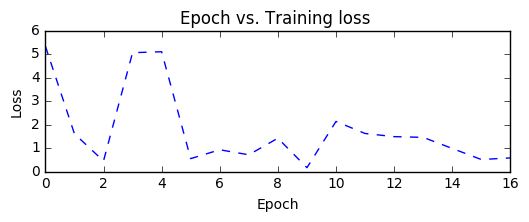

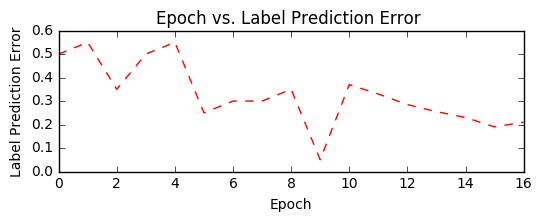

In [29]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["epoch"], moving_average(plotdata["loss"]), 'b--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Training loss ')

plt.show()

plt.subplot(212)
plt.plot(plotdata["epoch"], moving_average(plotdata["error"]), 'r--')
plt.xlabel('Epoch')
plt.ylabel('Label Prediction Error')
plt.title('Epoch vs. Label Prediction Error ')
plt.show()

## Проверяем модель 

Теперь необходимо проверить модель на тестовых данных с помощью `trainer.test_minibatch`. Полученная ошибка (validation error) должна примерно соответствовать ошибке при обучении (training error), в противном случае (если validation error существенно больше) это означает, что наша сеть перетренирована (**overfitting**). 

In [30]:
trainer.test_minibatch({input : features_test, label : labels_test}) 

0.05

### Посмотрим результаты 
Чтобы получить результаты для вычисленной выборки, применим `softmax` к полученном вектору `z` для получения вероятности принадлежности точки к тому или иному классу:  

In [31]:
out = softmax(z)
result = out.eval({input : features})
print(result[0][0:3])

[[  9.63782310e-01   3.62177193e-02]
 [  3.62619758e-01   6.37380183e-01]
 [  1.37170127e-05   9.99986291e-01]]


Теперь сравним полученные результаты с предсказанными значениями:

In [32]:
print("Label    :", np.argmax(labels[:25],axis=1))
print("Predicted:", np.argmax(result[0,:25,:],axis=1))

Label    : [0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0]
Predicted: [0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0]
